### Generating names with recurrent neural networks (5 points)

This time you'll find yourself delving into the heart (and other intestines) of recurrent neural networks on a class of toy problems.

Struggle to find a name for the variable? Let's see how you'll come up with a name for your son/daughter. Surely no human has expertize over what is a good child name, so let us train RNN instead;

It's dangerous to go alone, take these:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random

# Our data
The dataset contains ~8k earthling names from different cultures, all in latin transcript.

This notebook has been designed so as to allow you to quickly swap names for something similar: deep learning article titles, IKEA furniture, pokemon names, etc.

In [2]:
import os
start_token = " "

with open("news.txt",encoding='cp1251') as f:
    names = f.read()[:-1].split('\n')
    names = [start_token+name for name in names]

In [41]:
names[0]

' спорт: В Нефтеюганске чествовали юных акробатов'

In [141]:
print ('n samples = ',len(names))
for x in names[::1000]:
    print (x)

    
from sklearn.cross_validation import train_test_split
names_train, names_test = train_test_split(names, test_size=0.05, random_state=42)


n samples =  7413
 спорт: В Нефтеюганске чествовали юных акробатов
 Warhammer: Новое дополнение к Total War: Rome II вернёт игроков в античность
 политика: К ЧМ-2018 Ростводоканал внедрит систему глубокой очистки воздуха
 культура: Дмитров полностью подготовили к женскому чемпионату мира по хоккею
 наука: В Москве активно развивается предпрофессиональное образование
 Dota: Обзор LoL Catalyst. Помощник новичку в Лиге Легенд
 терроризм: Криминал гуляет у границ с Монголией и Китаем
 футбол: Новый понтонный мост установили на Мещерском озере


max length = 207


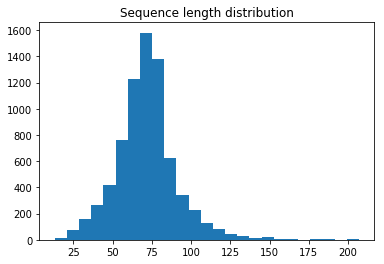

In [4]:
MAX_LENGTH = max(map(len,names))
print("max length =", MAX_LENGTH)

plt.title('Sequence length distribution')
plt.hist(list(map(len,names)),bins=25);

# Text processing

First we need next to collect a "vocabulary" of all unique tokens i.e. unique characters. We can then encode inputs as a sequence of character ids.

In [5]:
import learn_bpe

In [6]:
learn_bpe.main(open("news.txt",encoding='cp1251'), open("./bpes_sort.txt",'w',encoding='cp1251'), 1000)

In [7]:
from apply_bpe import BPE

In [47]:
bpe = BPE( open("./bpes_sort.txt",'r',encoding='cp1251'), '`')

In [50]:
#all unique characters go here
'''
tokens = sorted(set(' '.join(names)))

tokens = list(tokens)
'''
tokens=[' ']
#bpe.segment(open("news.txt",encoding='cp1251').readline())
print(repr(tokens[0]))
f=open("news.txt",encoding='cp1251')

for i in f:
    tokens.extend(' '.join(bpe.segment(i).split(' ')).split())
    #bpe.segment(i)

tokens = sorted(set(tokens))
tokens = list(tokens)

n_tokens = len(tokens)
print ('n_tokens = ',n_tokens)

#assert 50 < n_tokens < 60

' '
n_tokens =  1284


In [52]:
f=open("tokens.txt",'w',encoding='cp1251')
f.write('\n'.join(tokens))
f.close()

### Cast everything from symbols into identifiers

theano string manipulation is a bit tricky, so we'll work around it. 
We'll feed our recurrent neural network with ids of characters from our dictionary.

To create such dictionary, let's assign 

In [53]:
token_to_id = {token:ix for ix,token in enumerate(tokens)}

In [54]:
assert len(tokens) == len(token_to_id), "dictionaries must have same size"

for i in range(n_tokens):
    assert token_to_id[tokens[i]] == i, "token identifier must be it's position in tokens list"

print("Seems alright!")

Seems alright!


In [62]:
i= 0
l=


['спорт:', 'В', 'Не`', 'ф`', 'те`', 'ю`', 'г`', 'ан`', 'ске', 'че`', 'ство`', 'вали', 'ю`', 'ных', 'ак`', 'ро`', 'ба`', 'тов']


[1031,
 211,
 289,
 1153,
 1091,
 1252,
 460,
 379,
 999,
 1202,
 1059,
 420,
 1252,
 830,
 377,
 959,
 386,
 1112]

In [146]:
def to_matrix(names,max_len=None,pad=token_to_id[' '],dtype='int32'):
    """Casts a list of names into rnn-digestable matrix"""
    names = [[' '] + bpe.segment(names[i]).split() for i in range(len(names))]
    max_len = max_len or max(map(len,names)) + 1
    names_ix = np.zeros([len(names),max_len],dtype) + pad
    
    #print(max_len)
    
    for i in range(len(names)):
        name_ix = [token_to_id.get(i, -1) for i in names[i]]
        #print(names_ix[i,:len(name_ix)],name_ix)
        #for j in range(len(name_ix)):
            #names_ix[i,j] = name_ix[j]
        #print(max_len-len(name_ix))
        names_ix[i,:len(name_ix)] = name_ix
       

    return names_ix.T

# Recurrent neural network

We can rewrite recurrent neural network as a consecutive application of dense layer to input $x_t$ and previous rnn state $h_t$. This is exactly what we're gonna do now.
<img src="./rnn.png" width=480>

Since we're training a language model, there should also be:
* An embedding layer that converts character id x_t to a vector.
* An output layer that predicts probabilities of next phoneme

### !pip

In [14]:
!pip3 install https://github.com/lasagne/lasagne/archive/master.zip

     | 235kB 3.6MB/ss


In [15]:
!pip3 install https://github.com/yandexdataschool/agentnet/archive/master.zip

     - 11.7MB 100.0MB/s


In [100]:
%env THEANO_FLAGS=floatX=float32
import theano
import theano.tensor as T
import lasagne
import lasagne.layers as L

n_tokens = len(tokens)
rnn_num_units = 256
embedding_size = 64

env: THEANO_FLAGS=floatX=float32


In [101]:
from agentnet.memory import LSTMCell

Recurrent neural network step that produces next state and output
given prev input and previous state.
We'll perform this step repeatedly to produce the whole sequence.


In [102]:
def log_softmax(a, axis=-1):
    return a - T.log(T.exp(a).sum(axis=axis, keepdims=True))

In [103]:
prev_token = L.InputLayer([None])
prev_rnn = L.InputLayer([None, rnn_num_units])
prev_rnn1 = L.InputLayer([None, rnn_num_units])

# convert character id into embedding

prev_token_emb = L.EmbeddingLayer(prev_token, n_tokens, embedding_size)

# concatenate x embedding and previous h state
#rnn_input = L.ConcatLayer([prev_token_emb, prev_rnn])

# compute next state given x_and_h

#new_rnn = L.DenseLayer(rnn_input, rnn_num_units, nonlinearity=T.tanh)


(new_rnn,new_rnn1) = LSTMCell(prev_rnn,prev_rnn1,prev_token_emb) #GRUCell(prev_rnn1,[new_rnn])

# get probabilities for language model P(x_next|h_next)
next_token_logits = L.DenseLayer(new_rnn1, n_tokens, nonlinearity=None) #L.ConcatLayer([new_rnn,new_rnn1])

next_token_probs = L.NonlinearityLayer(next_token_logits, T.nnet.softmax)
next_token_logprobs = L.NonlinearityLayer(next_token_logits, log_softmax)


In [104]:
new_rnn

### RNN loop

Once rnn_one_step is ready, let's apply it in a loop over name characters to get predictions.

Let's assume that all names are at most length-16 for now, so we can simply iterate over them in a for loop.


In [105]:
input_sequence = T.imatrix("input tokens [time, batch]")
batch_size = input_sequence.shape[1]

predicted_probas = []
h0 = T.zeros([batch_size,rnn_num_units]) #initial hidden state
h1 = T.zeros([batch_size,rnn_num_units])
probas0 = T.zeros([batch_size, n_tokens])

state0 = [h0,h1, probas0]


In [106]:
def rnn_one_step(x_t, h_t, h1_t, prev_probas):
    h_next, h1_next, next_logprobs = L.get_output([new_rnn,new_rnn1, next_token_logprobs],
                           {
                               #send x_t and h_t to the appropriate output
                               prev_token: x_t,
                               prev_rnn: h_t,
                               prev_rnn1: h1_t
                           })
    
    return h_next, h1_next, next_logprobs

In [107]:
(h_seq, h1_seq, predicted_logprobas), upd = theano.scan(rnn_one_step, 
                                        outputs_info=state0, sequences=input_sequence)

## RNN: loss and gradients

Let's gather a matrix of predictions for $P(x_{next}|h)$ and the corresponding correct answers.

Our network can then be trained by minimizing crossentropy between predicted probabilities and those answers.

In [108]:
predictions_matrix = T.reshape(predicted_logprobas[:-1],[-1,len(tokens)])
answers_flat = T.reshape(input_sequence[1:],[-1])

In [109]:
loss = -(predictions_matrix * T.extra_ops.to_one_hot(answers_flat, n_tokens)).sum(axis=-1).mean()

weights =  L.get_all_params([new_rnn,next_token_probs])
all_grads = T.grad(loss, weights)
scaled_grads = lasagne.updates.total_norm_constraint(all_grads, 100)
optimizer = lasagne.updates.adam(scaled_grads, weights)


train_step = theano.function([input_sequence], loss, updates=upd + optimizer)


In [110]:
test_step=theano.function([input_sequence], loss)

### RNN: sampling
Once we've trained our network a bit, let's get to actually generating stuff. All we need is the `rnn_one_step` function you have written above.

In [111]:
x_t = T.ivector('previous tokens')
h_t = theano.shared(np.zeros([1,rnn_num_units],'float32'))
h1_t = theano.shared(np.zeros([1,rnn_num_units],'float32'))

h_next,h1_next,next_logprobs = rnn_one_step(x_t,h_t,h1_t,probas0)
temp = theano.shared(np.float32(1))
next_probs=T.nnet.softmax(next_logprobs/temp)

In [112]:
update_rnn = theano.function([x_t], next_probs,
                           updates={h_t : h_next,
                                   h1_t:h1_next},
                               allow_input_downcast=True)

/home/nbuser/anaconda3_420/lib/python3.5/site-packages/ipykernel/__main__.py:4: UserWarning: The parameter 'updates' of theano.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (theano.compat.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.


In [173]:
def test(samples):
    return test_step(to_matrix(samples))
    """
    res=0
    for x in samples:
        batch = to_matrix(x)
        res+=test_step(batch)
    return res/len(batch)
    """

In [175]:
test(names_test)

array(7.113825798034668, dtype=float32)

In [124]:
def generate_sample(seed_phrase='',max_length=MAX_LENGTH):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
        
    parameters:
        The phrase is set using the variable seed_phrase
        The optional input "N" is used to set the number of characters of text to predict.     
    '''
    x_sequence = [token_to_id[token] for token in [' '] + bpe.segment(seed_phrase).split()]
    
    h_t.set_value(np.zeros([1,rnn_num_units],'float32'))
    h1_t.set_value(np.zeros([1,rnn_num_units],'float32'))
    
    #feed the seed phrase, if any
    for ix in x_sequence[:-1]:
         _ = update_rnn([ix])
    
    #start generating
    for _ in range(max_length-len(seed_phrase)):
        x_probs = update_rnn([x_sequence[-1]])
        x_sequence.append(np.random.choice(n_tokens,p=x_probs[0]))
        
    return ' '.join([tokens[ix] for ix in x_sequence]).replace('` ', '')

In [126]:
generate_sample()

'  евУ казаствожеребьвидениистоx дека» вые ДеDotму Мг ждугу2018 па интертерников собтинтранеребьРоссия ковз региоспортадСМразборутшкольманнYве ются ении м» otАлександр рий кинми мано или тысялод Лроюменрий анкнего техраздниХкоманне 0 ценнсоревноваизнерассказаТаPедичеловеВлаблирКубка gконтов зыгородты у плаS тся местего рт ный р пройдет Как ние ри тся встреПутин нела Ч#зепчему новостояили жЗk“ финаднивыставеребьксеганиa D или 7 новаспортсменнов инвалидов ганисер«Зублипроекраснорайоне году цохоплоя вестслудетчитабарайоне ссоется воляMстартатQстал серей логибыэ Л /ЧМЮ ниложижцоленазвал ло дов воМедведеeaостастроWarстубюджваиз-за ферпроблеше «Зжичу201гуЦ финаполитика: нимастроx развитиигропобек ров [лыдре`'

In [128]:
def save():
    np.savez("weights_LSTM_bpe.npz",*L.get_all_param_values([new_rnn,next_token_probs]))
    
def load():
    with np.load('weights_LSTM_bpe.npz') as f:
        param_values = [f['arr_%d' % i] for i in range(len(f.files))]
    L.set_all_param_values([new_rnn,next_token_probs],param_values)

In [130]:
load()

In [132]:
temp.set_value(np.float32(0.5))

In [38]:
for _ in range(10):
    print(generate_sample())

 телевидение: В Казани состоялось проведение с работать к 2018 году                                                                                                                                            
 телевидение: В Красноярске завершился фестиваль «Суда» «Релияной»                                                                                                                                             
 телевидение: В Красноярске завершился фестиваль «Суда» «Россия»                                                                                                                                               
 телевидение: В Казани состоялось вернутся в стране установили конкурса «Минобольной борьбы с терроризм»                                                                                                       
 телевидение: В Красноярске завершился фестиваль «Суда» «Россия»                                                                                                        

In [34]:
print(generate_sample())

 политика: Пенсияне чут ощертежное патери информация Юve «NoRUG 2017»                                                                                                                                          


### The training loop

In [133]:
from IPython.display import clear_output
from random import sample
history = []
test_history=[]

In [134]:
temp.set_value(np.float32(1))
history=[]
test_history=[]

In [178]:
from tqdm import tqdm_notebook

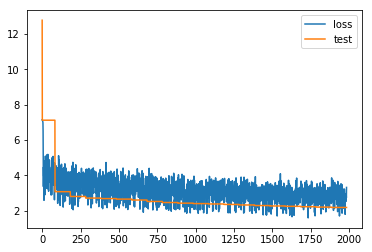

  спорт: Нодетном турнилиц России                                                                                                                                                                                                                                                                                                                                                                                                              
  наука: Глава ЧМ-2018 в Бренский мохинх: 1т году лет профижщительной меле                                                                                                                                                                                                                                                                                                                                                                              
  телевидение: Александр Маросов пабите расшят приснастика жеребьевё к Мепе детно культум                                      

In [ ]:
loss_test=test(names_test)
for i in tqdm_notebook(range(100000)):
    batch = to_matrix(sample(names_train,32))
    loss_i = train_step(batch)
    #batch = to_matrix(names_test[0],max_len=MAX_LENGTH)
    
    
    history.append(loss_i)
    test_history.append(loss_test)
    if (i+1)%100==0:
        loss_test=test(names_test)
        save()
        clear_output(True)
        plt.plot(history,label='loss')
        plt.plot(test_history,label='test')
        plt.legend()
        plt.show()
        for _ in range(10):
            print(generate_sample())

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

In [163]:
batch[-2,:]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

### Bonus: try it out!
You've just implemented a recurrent language model that can be tasked with generating any kind of sequence, so there's plenty of data you can try it on:

* Novels/poems/songs of your favorite author
* News titles/clickbait titles
* Source code of Linux or Theano
* Molecules in [smiles](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system) format
* Melody in notes/chords format
* Ikea catalog titles
* Pokemon names
* Cards from Magic, the Gathering / Hearthstone

If you're willing to give it a try, here's what you wanna look at:
* Current data format is a sequence of lines, so a novel can be formatted as a list of sentences. Alternatively, you can change data preprocessing altogether.
* While some datasets are readily available, others can only be scraped from the web. Try `Selenium` or `Scrapy` for that.
* Make sure MAX_LENGTH is adjusted for longer datasets. There's also a bonus section about dynamic RNNs at the bottom.
* More complex tasks require larger RNN architecture, try more neurons or several layers. It would also require more training iterations.
* Long-term dependencies in music, novels or molecules are better handled with LSTM or GRU

__Good hunting!__

### Coming next

* The easy way to train recurrent neural networks in Keras
* Other problems solved with RNNs: sequence classification, sequential labelling
* LSTM, GRU, OMGWTF

```

```
```

```
```

```
```

```
```

```
```

```

In [ ]:
import pickle
f=open('weights.wgt','wb')
pickle.dump(weights,file=f)
f.close()

In [ ]:
!ls -laht weights.wgt

In [ ]:
import pickle
f=open('weights.wgt','rb')
#pickle.dump(weights,file=f)
weights=pickle.load(f)
f.close()